In [201]:
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests


import matplotlib.pylab as pl
import time
import matplotlib.cm as cm
import matplotlib as mpl
import sys
import glob
import matplotlib.pyplot as plt
import numpy.ma as ma
# import mistree as mist
from matplotlib import colors
import math
import importlib
import environment

import tensorflow as tf

from IPython.display import Video, Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

clear_output()


In [1]:
import numpy as np
import nevopy as ne
from IPython.display import Video

from graphics import gen_vid
from settings import settings
import environment


In [ ]:
s = settings()


In [181]:
# ----- Neighborhood/Channel Parameters ----- 
moore_f = (np.array([ 1,  1,  1,  0,  0,  -1, -1, -1]),
           np.array([-1,  0,  1, -1,  1,  -1,  0,  1])) # Moore neigh indices

von_n = (np.array([-1,  0,  0, 1]),
         np.array([ 0, -1,  1,  0])) # Von Neumann neighborhood indices

moore_f = (np.array([ 1,  1,  1,  0,  0,  0,  -1, -1, -1]),
           np.array([-1,  0,  1, -1,  0,  1,  -1,  0,  1])) # Includes center

von_n_f = (np.array([-1,  0,  0,  0, 1]),
           np.array([ 0, -1,  0,  1,  0])) # Includes center

KERNEL = von_n
KERNEL_F = von_n_f
N_NEIGHS = len(KERNEL[0])
N_HIDDEN = 4
N_CHANNELS = 3 + N_HIDDEN # Number of channels per cell

LIFE = 0 # Index into channel
FOOD = 1 # Index into channel
RESV = 2
HIDDEN = 3 # Index of first hidden channel

# ----- Environment -----
ESIZE = 32 # width/height of the environment
ENV_SHAPE=(N_CHANNELS,ESIZE,ESIZE)
CUT_SHAPE = (ESIZE-2, ESIZE-2)
INDS = np.arange(0,CUT_SHAPE[0]*CUT_SHAPE[1])

# Lévy dust parameters (for distributing food)
ALPHA = 1. # 1.2 # Slope of the power law, to play with
BETA =  0.6 # 0.3 # Minimum step size of flight, to play with
FOOD_AMOUNT = 16 # Number of points created, they stack on each other
MAX_FOOD = 4

# ----- NN Attributes -----
# TODO: explore larger perceptive fields? sobel filters?
INPUT_SHAPE = (1 + N_NEIGHS) * N_CHANNELS # Center + neighs, all channels
OUTPUT_SHAPE = N_NEIGHS + N_HIDDEN # Center Life, resv from neighs, hidden channels for center

# ----- Physical Constraints -----
LIFE_COST = 0.3 # How much life is depleted per time step
MIN_LIFE = 0.1 # Life below this is treated as dead
LIFE_TRANSFER_RATE = 0.2 # Amount of food transferrable by 1 unit of life
FOOD_TRANSFER_RATE =  1 # Amount of life transferrable by 1 unit of food

In [183]:
class constraints:
  def __init__(self):
    self.life_cost=LIFE_COST
    self.min_life = MIN_LIFE
    self.life_transfer_rate=LIFE_TRANSFER_RATE
    self.food_transfer_rate=FOOD_TRANSFER_RATE
    self.max_life=1.

default_constraints = constraints()

In [184]:
#@title Old physics
'''
  - Life increases from food first (anywhere in neigh?)
  - Increase ^ is proportional to food val
  - Life drains from neigh life otherwise
  - Life decreases by DEATH_RATE every time step 
  - Only TRANSFER_RATE life can be drained from any one neighbor
  - 
'''
def apply_physics(center, neighs, desires, constraints=default_constraints):
  con=constraints
  if neighs[LIFE].sum() > 0 or center[LIFE] > 0:
    center[HIDDEN:] = desires[N_NEIGHS:]
    center[LIFE] += con.food_transfer_rate * center[FOOD] # Life appears on nearby food
    center[LIFE] = min(center[LIFE],con.max_life)

    if center[LIFE] > con.min_life or sum(desires[:N_NEIGHS]) > 0.1:
      # Neighbor's life will change by at most what they can transfer
      delta_neigh = np.minimum(con.life_transfer_rate * neighs[LIFE],desires[:N_NEIGHS])
      delta_center = sum(delta_neigh)
      # A cell can only hold 1 unit of life
      adj = min(delta_center, (con.max_life-center[LIFE]))/delta_center
      neighs[LIFE] -= delta_neigh * adj
      center[LIFE] += delta_center * adj

    center[LIFE] -= center[LIFE] * con.life_cost
    center[LIFE] = min(center[LIFE],con.max_life)
    if center[LIFE] <= con.min_life:
      center[LIFE] = 0

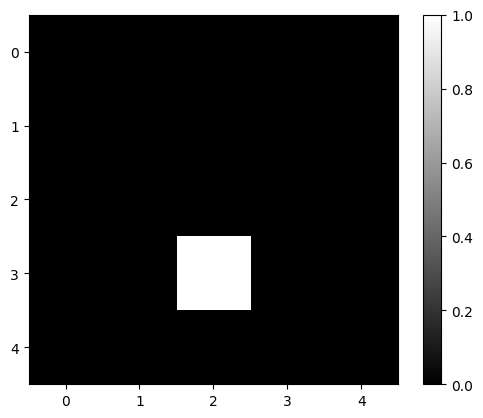

AFTER


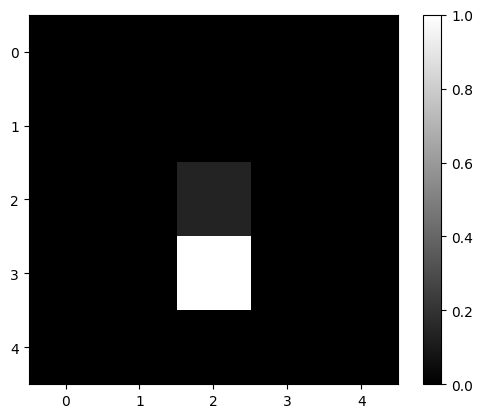

In [185]:
#@title Slime mold env tests
# Test create new cell that is less than sum
# channel 1 is food, channel 2 is life
env1 = np.zeros((N_CHANNELS,ESIZE,ESIZE))
env1[FOOD, 5:8,3:6] =  np.array([[0,0,0],
                                  [0,0,0],
                                  [0,0,0]])

env1[LIFE,5:8,3:6] = np.array([[0,0,0],
                                [0,0,0],
                                [0,1,0]])
desire = np.arange(N_NEIGHS + N_HIDDEN)
desire[1:1+N_NEIGHS] = [1,1,1,1]
desire[LIFE] = 1

# for i in range(3):
#   apply_constraints(env1[:,6,4], env1[:,KERNEL[0] + 6, KERNEL[1] + 4], desire)
ch_plot(env1[:,4:9,2:7],LIFE)
print("AFTER")
apply_physics(env1[:,6,4], env1[:,KERNEL[0] + 6, KERNEL[1] + 4], desire)
ch_plot(env1[:,4:9,2:7],LIFE)

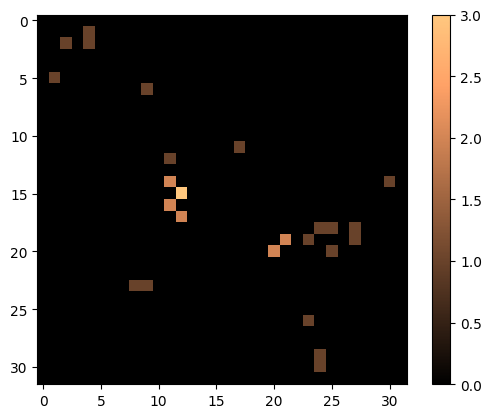

In [191]:
def gen_padded_env(shape=(ESIZE,ESIZE), pad=1, points=FOOD_AMOUNT, alpha=ALPHA, beta=BETA, food_scaler=1):
    env = np.zeros((N_CHANNELS, shape[0], shape[1])) # TODO: Randomize initial grid?

    dust = levy_dust.get_levy_dust((shape[0]-pad*2, shape[1]-pad*2), points, alpha, beta).T
    dust = np.array(dust, dtype=np.int64)
    dust, density = np.unique(dust, axis=0, return_counts=True)

    env[FOOD,dust[:,0]+1,dust[:,1]+1] = density
    return env

# Innoculate the cell with the most food - this is likely to be surrounded 
# by more food given def of levy dust
def innoculate_env(env):
  maxfood = np.unravel_index(np.argmax(env[FOOD]), env[FOOD].shape)
  env[LIFE][maxfood[0],maxfood[1]] = 1
  return env

env=gen_padded_env(points=32, alpha=1, beta=1)
ch_plot(env, FOOD)

In [187]:
#@title Tester Agents
class RandomAgent:
    def reset(self):
        pass

    def process(self, x):
        # y = np.random.randint(2)
        return np.random.rand(OUTPUT_SHAPE)

class LameAgent:
    def __init__(self,mult):
      self.mult=mult

    def reset(self):
        pass
    def process(self, x):
        # y = np.random.randint(2)
        y=np.zeros(OUTPUT_SHAPE)
        y[:N_NEIGHS] += [self.mult,self.mult,self.mult,self.mult]
        return y 

In [188]:
#@title Apply agent to environmet

def add_frame(frames, env):
  fframe = ch_image(env,FOOD, cmap=cm.copper)
  lframe = ch_image(env,LIFE, cmap=cm.gray)
  frame = np.append(fframe,lframe, axis=0)
  if frames is None:
    frames = np.array([frame])
  else:
    frames = np.append(frames, [frame], axis=0)
  return frames

def add_frames(frames, new_frames):
  if new_frames is not None and len(new_frames) > 0:
    if frames is None:
      frames = new_frames
    else:
      frames = np.append(frames, new_frames,axis=0)
  return frames

# Stochastically applies agent to every alive cell
def apply_agent(agent, env, gen_frames=False, vid_speed=10, constraints=default_constraints):
  np.random.shuffle(INDS)
  coords = np.unravel_index(INDS, CUT_SHAPE)
  frames = None

  total_steps = 0
  # start one index in, the list is 2 short so it will stop with one to go
  for i,j in zip(coords[0]+1,coords[1]+1): 
    input = env[:,KERNEL_F[0]+i,KERNEL_F[1]+j]
    if input[LIFE].sum() > 0:
      desires = agent.process(input.flatten())
      apply_physics(env[:,i,j],env[:,KERNEL[0]+i,KERNEL[1]+j], desires, constraints=constraints)

      if gen_frames and vid_speed < 10 and total_steps%(math.pow(2,vid_speed)) == 0:
        frames = add_frame(frames,env)
    
      total_steps += 1

  if gen_frames:
    frames = add_frame(frames, env)

  return frames

# Vid speed of 10 generates a frame for every full application of an agent
def apply_agent_n(agent, env, n=10, apply_until_dead=False, gen_frames=False, vid_speed=10, constraints=constraints):
  frames=None
  i=0
  fitness = 0
  running=True
  # tot_delta=0
  while running:
    temp_frames = apply_agent(agent, env, gen_frames, vid_speed, constraints=constraints)
    if gen_frames:
      frames = add_frames(frames,temp_frames)

    if apply_until_dead:
      running = env[LIFE].sum() > 0 
    else:
      running = i<n
    i+=1
  return frames

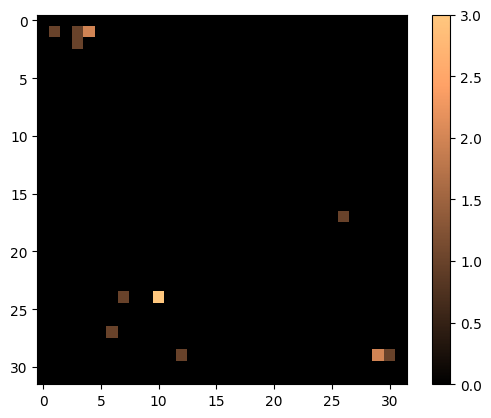

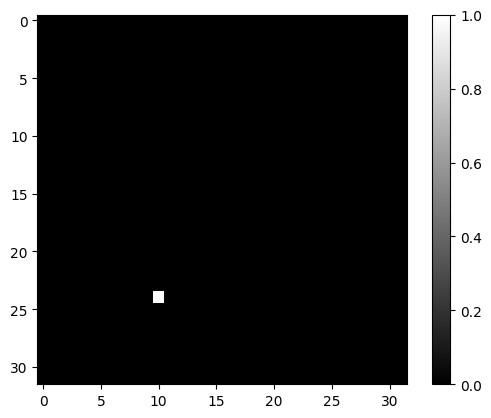

In [198]:
test_env = gen_padded_env(points=15, alpha=1., beta=1.)
test_env = innoculate_env(test_env)
ch_plot(test_env,FOOD)
ch_plot(test_env,LIFE)
# imshow(zoom(ch_image(test_env,FOOD),16))
# imshow(zoom(ch_image(test_env,LIFE, cmap = cm.cool),16))
agent=RandomAgent()
# np.unravel_index(np.argmax(test_env[LIFE]),test_env.shape)

In [199]:
my_cons = constraints()
my_cons.min_life = 0.1
my_cons.food_transfer_rate = 0.5
my_cons.life_cost = 0.35
my_cons.life_transfer_rate = .3
my_cons.max_life = 10.0

frames = apply_agent_n(RandomAgent(), np.copy(test_env), n=50, gen_frames=True, vid_speed=8, constraints=my_cons)
# mvp.ipython_display(gen_vid(frames))
Video(gen_vid(frames))